# Exercise 3: Tackling the Titanic dataset

## Load data

In [338]:
import pandas as pd

train_path = "./datasets/titanic/train.csv"
test_path = "./datasets/titanic/test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Set colnames to lowercase
train_df.columns = [col.lower() for col in train_df.columns]
test_df.columns = [col.lower() for col in test_df.columns]

## EDA

In [339]:
train_df.shape

(891, 12)

In [340]:
train_df.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [341]:
train_df.describe()

,passengerid,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [342]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [343]:
cols_remove = [
    "passengerid",
    "name",
    "ticket"
]

train_df = train_df.drop(cols_remove, axis=1)

## Transformation pipeline

In [344]:
# X_train and y_train

X_train = train_df.drop("survived", axis=1)
y_train = train_df["survived"].copy()

In [345]:
cat_feats = train_df.select_dtypes(include="object").columns.tolist()
num_feats = train_df.select_dtypes(exclude="object").columns.tolist()
num_feats.remove("survived")

print("Categorical features: ", cat_feats)
print("Numerical features: ", num_feats)

Categorical features:  ['sex', 'cabin', 'embarked']
Numerical features:  ['pclass', 'age', 'sibsp', 'parch', 'fare']


### Categorical features

#### Sex

In [346]:
train_df["sex"].value_counts()

sex
male      577
female    314
Name: count, dtype: int64

#### Cabin

In [347]:
train_df["cabin"].value_counts()

cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64

In [348]:
def get_cabin_info(cabin):
    if cabin is None or type(cabin) is not str:
        return "Unknown", -1
    
    # Split in spaces
    cabins = cabin.split(" ")
    for c in cabins:
        letter = c[0]
        num = c[1:]
        if letter.isalpha() and num.isdigit():
            return letter, num
    return "Unknown", -1

In [349]:
# Transformer to extract cabin info
# If true, adds cabin info cols for letter and number

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
import numpy as np

class CabinInfoExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, add_cabin_info=True):
        self.add_cabin_info = add_cabin_info
        self.ohe = OneHotEncoder()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.add_cabin_info:
            letter, num = np.array([get_cabin_info(cabin) for cabin in X["cabin"]]).T
            # encode letter
            letter = self.ohe.fit_transform(letter.reshape(-1, 1)).toarray()
            return np.c_[letter, num]
        else:
            return X

In [350]:
# Test transformer
cabin_info_extractor = CabinInfoExtractor()
cabin_info_extractor.fit_transform(train_df)

# Print first 10
train_df["cabin"].head(10)

0     NaN
1     C85
2     NaN
3    C123
4     NaN
5     NaN
6     E46
7     NaN
8     NaN
9     NaN
Name: cabin, dtype: object

In [351]:
# Print first 10 transformed
cabin_info_extractor.transform(train_df)[:10]

array([['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '1.0', '-1'],
       ['0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0', '85'],
       ['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '1.0', '-1'],
       ['0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0', '123'],
       ['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '1.0', '-1'],
       ['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '1.0', '-1'],
       ['0.0', '0.0', '0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '46'],
       ['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '1.0', '-1'],
       ['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '1.0', '-1'],
       ['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '1.0', '-1']],
      dtype='<U32')

#### Embarked

In [352]:
train_df["embarked"].value_counts()

embarked
S    644
C    168
Q     77
Name: count, dtype: int64

#### Categorical pipeline

In [353]:
# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = ColumnTransformer([
    ("ohes", OneHotEncoder(), ["sex", "embarked"]),
    ("cabin_info", CabinInfoExtractor(), ["cabin"])
])

In [354]:
# Test pipeline
cat_pipeline.fit_transform(train_df)

# First 10 transformed
cat_pipeline.transform(train_df)[:10]

array([['0.0', '1.0', '0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0', '1.0', '-1'],
       ['1.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0', '1.0',
        '0.0', '0.0', '0.0', '0.0', '0.0', '85'],
       ['1.0', '0.0', '0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0', '1.0', '-1'],
       ['1.0', '0.0', '0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '1.0',
        '0.0', '0.0', '0.0', '0.0', '0.0', '123'],
       ['0.0', '1.0', '0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0', '1.0', '-1'],
       ['0.0', '1.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0', '1.0', '-1'],
       ['0.0', '1.0', '0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '1.0', '0.0', '0.0', '0.0', '46'],
       ['0.0', '1.0', '0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0', '1.0', '-1'],
       ['1.0', '0.0', '0.0', '0

### Numerical features

#### Pclass

In [355]:
train_df["pclass"].value_counts()

pclass
3    491
1    216
2    184
Name: count, dtype: int64

#### Age

In [356]:
train_df["age"].value_counts()

age
24.00    30
22.00    27
18.00    26
19.00    25
28.00    25
         ..
36.50     1
55.50     1
0.92      1
23.50     1
74.00     1
Name: count, Length: 88, dtype: int64

#### Sibsp

In [357]:
train_df["sibsp"].value_counts()

sibsp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64

#### Parch

In [358]:
train_df["parch"].value_counts()

parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64

#### Fare

In [359]:
train_df["fare"].value_counts()

fare
8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
35.0000     1
28.5000     1
6.2375      1
14.0000     1
10.5167     1
Name: count, Length: 248, dtype: int64

#### Numerical pipeline

In [360]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

#### Full pipeline

In [361]:
full_pipeline = ColumnTransformer([
    ("cat", cat_pipeline, cat_feats),
    ("num", num_pipeline, num_feats)
])

## Training a model

The test set that comes with the Titanic dataset does not include labels to train with.
We will have to split the training set into a training and a validation set.

### Basic training

In [362]:
X_train_prepared = full_pipeline.fit_transform(X_train).astype(np.float32)

In [363]:
X_train_prepared.shape

(891, 20)

In [364]:
X_train_prepared[:2]

array([[ 0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        , -1.        ,
         0.82737726, -0.5657365 ,  0.43279338, -0.4736736 , -0.50244516],
       [ 1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , 85.        ,
        -1.5661069 ,  0.66386104,  0.43279338, -0.4736736 ,  0.78684527]],
      dtype=float32)

In [365]:
# SGD Classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(random_state=42)

In [366]:
# Cross validation
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train_prepared, y_train, cv=3, scoring="accuracy")

array([0.74410774, 0.74747475, 0.76094276])

### Grid search

In [367]:
# grid search
from sklearn.model_selection import GridSearchCV

param_grid = [
    {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10], "penalty": ["l1", "l2"]},
    {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10], "penalty": ["elasticnet"], "l1_ratio": [0.25, 0.5, 0.75]},
    {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10], "penalty": ["none"]}
]

grid_search = GridSearchCV(sgd_clf, param_grid, cv=3, scoring="accuracy", return_train_score=True, verbose=1)
grid_search.fit(X_train_prepared, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


c:\Users\faguilera\miniconda3\envs\ml\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
18 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\faguilera\miniconda3\envs\ml\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\faguilera\miniconda3\envs\ml\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\faguilera\miniconda3\envs\ml\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints

GridSearchCV(cv=3, estimator=SGDClassifier(random_state=42),
             param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                          'penalty': ['l1', 'l2']},
                         {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                          'l1_ratio': [0.25, 0.5, 0.75],
                          'penalty': ['elasticnet']},
                         {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                          'penalty': ['none']}],
             return_train_score=True, scoring='accuracy', verbose=1)

In [368]:
# Best params and score
grid_search.best_params_

{'alpha': 0.01, 'l1_ratio': 0.5, 'penalty': 'elasticnet'}

In [369]:
# Cross val score
cross_val_score(grid_search.best_estimator_, X_train_prepared, y_train, cv=3, scoring="accuracy")

array([0.78787879, 0.7979798 , 0.78114478])

## Measuring performance

### Confusion matrix

In [370]:
# confussion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(grid_search.best_estimator_, X_train_prepared, y_train, cv=3)
confusion_matrix(y_train, y_train_pred)

array([[468,  81],
       [107, 235]], dtype=int64)

### Precision and recall

In [371]:
# Precision and recall
from sklearn.metrics import precision_score, recall_score

print("Precision: ", precision_score(y_train, y_train_pred))
print("Recall: ", recall_score(y_train, y_train_pred))

Precision:  0.7436708860759493
Recall:  0.6871345029239766


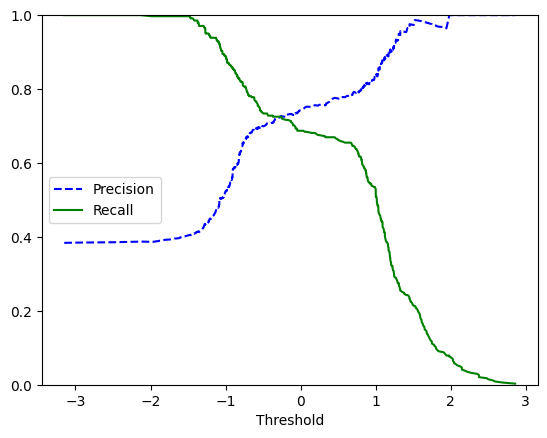

In [372]:
# Plot precision and recall and threshold
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_scores = cross_val_predict(grid_search.best_estimator_, X_train_prepared, y_train, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
    plt.show()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)


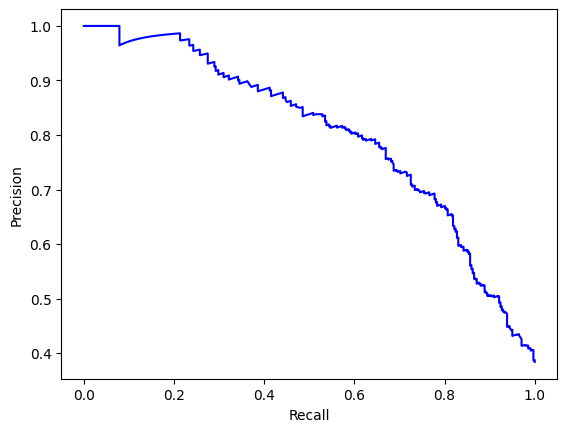

In [373]:
# Plot precision vs recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

plot_precision_vs_recall(precisions, recalls)

### AUC ROC

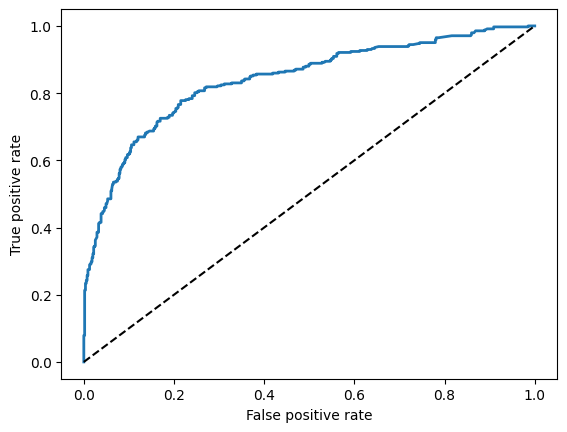

In [374]:
# AUC 
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], "k--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.show()

plot_roc_curve(fpr, tpr)

In [375]:
# AUC score
roc_auc_score(y_train, y_scores)

0.8398736671673112

## Predictions on testing

In [376]:
test_df.head()

,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [377]:
X_test_prepared = full_pipeline.transform(test_df).astype(np.float32)

X_test_prepared.shape

(418, 20)

In [378]:
# Make predictions
y_test_pred = grid_search.best_estimator_.predict(X_test_prepared)

In [380]:
# Merge passenger id and predictions
passenger_id = test_df["passengerid"]
predictions = pd.DataFrame({"PassengerId": passenger_id, "Survived": y_test_pred})

predictions.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [381]:
# Save predictions to csv
predictions.to_csv("./datasets/titanic/predictions.csv", index=False)

## Create a pipeline to automate the process

In [382]:
# We already have full_pipeline.
# We need to plug the stimator with a grid search, select best model, and predict

param_grid

[{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']},
 {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
  'penalty': ['elasticnet'],
  'l1_ratio': [0.25, 0.5, 0.75]},
 {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'penalty': ['none']}]

In [384]:
from sklearn.preprocessing import FunctionTransformer

def to_float(X):
    return X.astype(np.float64)

to_float_transformer = FunctionTransformer(to_float)
prediction_pipeline = Pipeline([
    ("full_pipeline", full_pipeline),
    ("to_float", to_float_transformer),
    ("grid_search", grid_search)
])

prediction_pipeline.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


c:\Users\faguilera\miniconda3\envs\ml\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
18 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\faguilera\miniconda3\envs\ml\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\faguilera\miniconda3\envs\ml\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\faguilera\miniconda3\envs\ml\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints

Pipeline(steps=[('full_pipeline',
                 ColumnTransformer(transformers=[('cat',
                                                  ColumnTransformer(transformers=[('ohes',
                                                                                   OneHotEncoder(),
                                                                                   ['sex',
                                                                                    'embarked']),
                                                                                  ('cabin_info',
                                                                                   CabinInfoExtractor(),
                                                                                   ['cabin'])]),
                                                  ['sex', 'cabin', 'embarked']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['pclass', 'age', 'sibsp',...
                ('grid_search',
                 GridSearchCV(cv=3, estimator=SGDClassifier(random_state=42),
                              param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.1,
                                                     1, 10],
                                           'penalty': ['l1', 'l2']},
                                          {'alpha': [0.0001, 0.001, 0.01, 0.1,
                                                     1, 10],
                                           'l1_ratio': [0.25, 0.5, 0.75],
                                           'penalty': ['elasticnet']},
                                          {'alpha': [0.0001, 0.001, 0.01, 0.1,
                                                     1, 10],
                                           'penalty': ['none']}],
                              return_train_score=True, scoring='accuracy',
                              verbose=1))])

In [390]:
# Get best estimator
best_estimator = prediction_pipeline.named_steps["grid_search"].best_estimator_

# Make predictions
y_test_pred = best_estimator.predict(X_test_prepared)


In [392]:
# Cross val score, F1 score, precision, recall
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score

print("F1 score: ", f1_score(y_train, y_train_pred))
print("Precision: ", precision_score(y_train, y_train_pred))
print("Recall: ", recall_score(y_train, y_train_pred))

F1 score:  0.7142857142857143
Precision:  0.7436708860759493
Recall:  0.6871345029239766
